<a href="https://colab.research.google.com/github/HW0327/Electromagnetism-Project/blob/main/CNN4_Predicting_current_on_sensor_plane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import math
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.layers import *

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)


In [3]:
I_values=np.linspace(100,1099,100)
sx=np.linspace(-0.02,0.02,64)  # x-position of the testing point
sy=np.linspace(-0.02,0.02,64)  # y-position of the testing point
wx=np.linspace(-0.1,0.1,100)
H=0.015
mu_0 = 4 * math.pi * 1e-7  # Permeability of free space

In [4]:

# Create a list to store the rows of data

fm=[]
# Loop over the I and R values and calculate the corresponding B values
for n in wx:
  for I in I_values:
    mm=[]
    for m in sx:
      mmm=[]
      for j in sy:
        R=np.sqrt(H**2+abs(n-m)**2)
        B = mu_0 * I / (2 * math.pi * R)
        mmm.append(B)
      mm.append(mmm)
    fm.append(mm)


In [5]:
shape = np.shape(fm)
shape

(10000, 64, 64)

In [6]:
I_grid, wx_grid = np.meshgrid(I_values, wx)

# Reshape the grids into 1D arrays
I_array = I_grid.reshape(-1)
wx_array = wx_grid.reshape(-1)

# Stack the arrays horizontally to create a 2D array with shape (2000, 2)
combined_array = np.hstack((wx_array.reshape(-1, 1), I_array.reshape(-1, 1)))
combined_array

array([[-1.00000000e-01,  1.00000000e+02],
       [-1.00000000e-01,  1.10090909e+02],
       [-1.00000000e-01,  1.20181818e+02],
       ...,
       [ 1.00000000e-01,  1.07881818e+03],
       [ 1.00000000e-01,  1.08890909e+03],
       [ 1.00000000e-01,  1.09900000e+03]])

In [7]:
np.shape(combined_array)

(10000, 2)

In [31]:


# Reshape the input data into a 4D array
fm = np.array(fm)
fm = fm.reshape(fm.shape[0], 64, 64, 1)
# Normalize the input data
scaler = MinMaxScaler()
fm_normalized = scaler.fit_transform(fm.reshape(fm.shape[0], -1))
fm_normalized = fm_normalized.reshape(fm.shape[0], 64, 64, 1)

combined_array_normalized = scaler.fit_transform(combined_array)
combined_array_normalized = combined_array_normalized.reshape(fm.shape[0], 2, 1)

# Split the data into training and validation sets
x_trainn, x_test, y_trainn, y_test = train_test_split(fm_normalized, combined_array_normalized, test_size=0.2, random_state=42, shuffle=True,)
x_train, x_val, y_train, y_val = train_test_split(x_trainn, y_trainn, test_size=0.2, random_state=42, shuffle=True,)
# Define the CNN model
model = keras.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='linear'))

# Compile the model
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, start_from_epoch=100,baseline=3e-4, restore_best_weights=True,verbose=1)
# Create the model
model.summary()

# Train the model
history = model.fit(x_train, y_train, epochs=200, batch_size=32, shuffle=True, callbacks=[callback], validation_data=(x_val, y_val),verbose=1)

# Make predictions on new data
y_pred = model.predict(x_test) # Predict the output data


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 12544)             0         
                                                                 
 dense_10 (Dense)            (None, 64)               

In [32]:
y_test=data = np.squeeze(y_test, axis=2)
diff=0
for i in range(len(y_pred)):
  diff+=abs(y_pred[i]-y_test[i])
#Calculate model accuracy by dividing the total errors in the predictions by the number of predictions
diff=1-diff/y_test.shape[0]
print(f'Predicting posion of the wire with acccuracy of {diff[0]}')
print(f'Predicting current intensity with acccuracy of {diff[1]}')

Predicting posion of the wire with acccuracy of 0.9885841700031299
Predicting current intensity with acccuracy of 0.9887320419590582


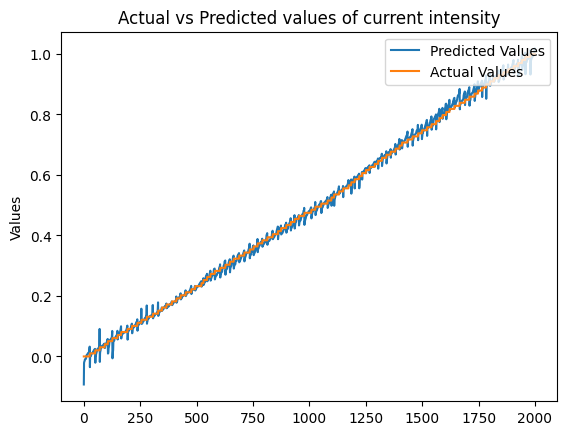

In [33]:
paired_array = list(zip(y_test[:, 1], y_pred[:, 1]))

# Sorting the paired array by the first element in each subarray using sorted()
sorted_array = sorted(paired_array)
y_test1, y_pred1 = zip(*sorted_array)
plt.plot(y_pred1, label='Predicted Values')
plt.plot(y_test1, label='Actual Values')
plt.ylabel("Values")
plt.title("Actual vs Predicted values of current intensity")
plt.legend(loc="upper right")

plt.show()

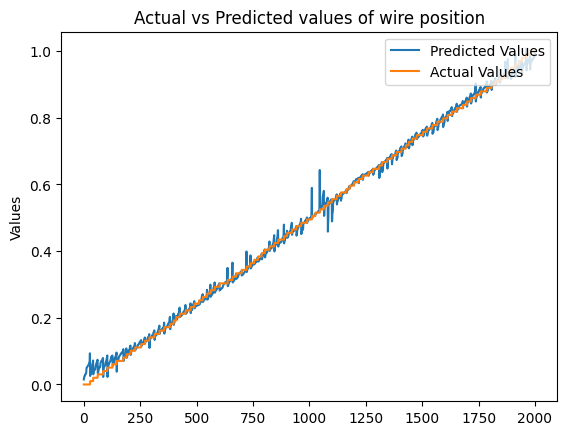

In [34]:
paired_array = list(zip(y_test[:, 0], y_pred[:, 0]))

# Sorting the paired array by the first element in each subarray using sorted()
sorted_array = sorted(paired_array)
y_test0, y_pred0 = zip(*sorted_array)
plt.plot(y_pred0, label='Predicted Values')
plt.plot(y_test0, label='Actual Values')
plt.ylabel("Values")
plt.title("Actual vs Predicted values of wire position")
plt.legend(loc="upper right")

plt.show()